In [1]:
import os,sys
curr_path = os.getcwd()
sys.path.append('../../codes')
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
import datetime
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

import torch
from itertools import count
import gym
from agent import Agent
from memory import ReplayBuffer,NaivePrioritizedBuffer,NStepReplayBuffer
from common.plot import plot_rewards
from common.utils import save_results,make_dir

# multi-envs + 1 agent

In [2]:
from common.atari_wrappers import make_atari, wrap_deepmind, wrap_pytorch
import tianshou as ts
# from common.multiprocessing_env import SubprocVecEnv

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# !pip install box2d-py # for box2d envs
def make_env(env_id,seed=1):
    if 'Pong' in env_id:
        env = make_atari(env_id)
        env = wrap_deepmind(env,episode_life=True)
        env = wrap_pytorch(env) 
    else:
        env = gym.make(env_id)
    if seed: env.seed(seed)
    return env
def init_envs_agent(cfg,nenv,seed=1):
    envs = ts.env.ShmemVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
#     envs = ts.env.SubprocVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
    if len(envs.observation_space[0].shape) == 1:
        state_dim = envs.observation_space[0].shape[0]
    else:
        state_dim = envs.observation_space[0].shape
        
    if 'Continuous' in cfg.model:
        cfg.max_act = envs.action_space[0].high[0]
        action_dim = envs.action_space[0].shape[0]
    else:
        action_dim = envs.action_space[0].n
        
    agent = Agent(state_dim,action_dim,cfg)
    return envs,agent
    
#<ImageToPyTorch<ClipRewardEnv<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>

In [4]:
### slower than ts.env.SubprocVectorEnv ###
# from common.multiprocessing_env import SubprocVecEnv
# def make_env(env_name,seed=1):
#     env = make_atari(env_name)
#     env = wrap_deepmind(env,episode_life=False)
#     env = wrap_pytorch(env) 
#     return env
# def init_envs_agent(cfg,nenv,seed=1):
#     envs = SubprocVecEnv([lambda:make_env(cfg.env_id) for i in range(nenv)])
#     state_dim = envs.observation_space.shape
#     action_dim = envs.action_space.n
#     agent = Agent(state_dim,action_dim,cfg)
#     return envs,agent

In [5]:
def train(cfg,envs,agent):
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    envs.seed(cfg.seed)
    
    print('Start Training!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames'],history['loss']  = [],[],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_train_env),np.zeros(cfg.n_train_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0
    memorys = [NStepReplayBuffer(cfg.n_multi_step,cfg.gamma, ReplayBuffer(cfg.memory_size)) 
                for _ in range(cfg.n_train_env)]

    states = envs.reset()
    while i_frame < cfg.max_train_frames: #1500000: #
        ### interactive with environments ###
        actions = agent.sample(states)
        if cfg.n_train_env == 1: actions = [actions]
    #     actions = np.random.randint(6,size=cfg.n_train_env)
        next_states,rewards,dones,infos = envs.step(actions)
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        for memory,s,a,r,next_s,done in zip(memorys, states, actions, rewards, next_states, dones):
            memory.push(s,a,r,next_s,done)
        states = next_states
        i_frame += len(actions)
        ### updating agent ###
        if all([len(memory)>cfg.memory_warmup_size for memory in memorys]) and i_frame%cfg.learn_freq==0:
            batch_state,batch_action,batch_reward,batch_next_state,batch_done = [],[],[],[],[]
            sample_ids = np.random.choice(cfg.n_train_env,cfg.batch_size,p=[1/cfg.n_train_env]*cfg.n_train_env)
            sample_num = np.bincount(sample_ids, minlength=cfg.n_train_env)
            sample_num[sample_num==0] = 4
            for i,n in enumerate(sample_num):
                s,a,r,ns,d = memorys[i].sample(n)
                for batch, x in zip([batch_state,batch_action,batch_reward,batch_next_state,batch_done],
                                    [s,a,r,ns,d]):
                    batch.append(x)
            batch_state,batch_action,batch_reward,batch_next_state,batch_done = map(
                lambda x:np.concatenate(x),[batch_state,batch_action,batch_reward,batch_next_state,batch_done])
            loss = agent.learn(batch_state,batch_action,batch_reward,batch_next_state,batch_done)
            history['loss'].append(loss)
        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
    #         print(history,done_envs_ids,eps_rewards)aa
    #         break
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 1000:
                prev_frame_verbose = history['frames'][-1]
                if history['loss']:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}: Loss:{history['loss'][-1]:.4f}")
                else:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
            if history['frames'][-1] - prev_frame_save >= cfg.max_train_frames//10:
                prev_frame_save = history['frames'][-1]
                make_dir(cfg.result_path,cfg.model_path+time)
                agent.save(path=cfg.model_path+time+'/')
    make_dir(cfg.result_path,cfg.model_path+time)
    agent.save(path=cfg.model_path+time+'/')
    return history

In [6]:
def evaluate(cfg,envs,agent,render=False):
    envs.seed(1)
    print('Start Evaluating!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames']  = [],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_eval_env),np.zeros(cfg.n_eval_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0

    states = envs.reset()
    while i_frame < cfg.max_eval_frames:
        ### interactive with environments ###
        if render: envs.render()
        actions = agent.predict(states).cpu().numpy()
        if cfg.n_eval_env == 1: actions = [actions]
        next_states,rewards,dones,infos = envs.step(actions)
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        states = next_states
        i_frame += len(actions)

        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
            
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 10:
                prev_frame_verbose = history['frames'][-1]
                print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
    return history

In [7]:
def main():
    cfg = config()
    print(cfg.agent,cfg.env_id)
    
    envs,agent = init_envs_agent(cfg,cfg.n_train_env)
    history = train(cfg,envs,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(history,tag='train',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="train",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

    eval_envs,agent = init_envs_agent(cfg,cfg.n_eval_env,seed=10)
    agent.load(path=cfg.model_path)
    history = evaluate(cfg,eval_envs,agent,render=False)
    save_results(history,tag='eval',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="eval",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

# Pendulum-v0

In [18]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'DDPG'             # name of agent
        self.env_id = 'Pendulum-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 6e5     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 600  # number of experience stored in memory before learning
        self.learn_freq = 2            # number of steps for one learning 
#         self.sync_target_freq = 1     # number of learning steps for sync target model
        self.batch_size = 512          # number of examples in one batch
        self.soft_tau = 0.01           # parm for soft updating target model
        self.actor_lr = 0.0001         # learning rate of policy opt
        self.critic_lr = 0.0001        # learning rate of value opt
        self.gamma = 0.90              # discount rate of reward
#         self.n_multi_step = 1          # number of steps of multi-step style gain 
        self.epsilon_start = 0.90      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.001        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'Continuous'       # name or type of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 2.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

DDPG Pendulum-v0
Start Training!
20210816-152713
[20210816-152714: DDPG] Episode:16: Frame:3200.0: Reward:-1790.1
[20210816-152714: DDPG] Episode:32: Frame:6400.0: Reward:-1297.2
[20210816-152715: DDPG] Episode:48: Frame:9600.0: Reward:-1098.9
[20210816-152719: DDPG] Episode:64: Frame:12800.0: Reward:-1333.9: Loss:37.2116
[20210816-152722: DDPG] Episode:80: Frame:16000.0: Reward:-1403.0: Loss:47.1246
[20210816-152726: DDPG] Episode:96: Frame:19200.0: Reward:-1185.3: Loss:58.4444
[20210816-152730: DDPG] Episode:112: Frame:22400.0: Reward:-1636.2: Loss:66.5386
[20210816-152734: DDPG] Episode:128: Frame:25600.0: Reward:-1566.9: Loss:64.1013
[20210816-152738: DDPG] Episode:144: Frame:28800.0: Reward:-1688.1: Loss:69.0149
[20210816-152742: DDPG] Episode:160: Frame:32000.0: Reward:-1405.3: Loss:71.7677
[20210816-152746: DDPG] Episode:176: Frame:35200.0: Reward:-1600.8: Loss:81.1693
[20210816-152750: DDPG] Episode:192: Frame:38400.0: Reward:-1426.3: Loss:63.6414
[20210816-152753: DDPG] Episod

[20210816-153222: DDPG] Episode:1632: Frame:326400.0: Reward:-130.3: Loss:38.9341
[20210816-153226: DDPG] Episode:1648: Frame:329600.0: Reward:-127.2: Loss:30.9739
[20210816-153229: DDPG] Episode:1664: Frame:332800.0: Reward:-253.8: Loss:30.6918
[20210816-153233: DDPG] Episode:1680: Frame:336000.0: Reward:-358.8: Loss:27.0969
[20210816-153239: DDPG] Episode:1696: Frame:339200.0: Reward:-131.3: Loss:29.9830
[20210816-153245: DDPG] Episode:1712: Frame:342400.0: Reward:-265.0: Loss:32.2173
[20210816-153251: DDPG] Episode:1728: Frame:345600.0: Reward:-246.4: Loss:29.0716
[20210816-153257: DDPG] Episode:1744: Frame:348800.0: Reward:-258.8: Loss:26.8444
[20210816-153302: DDPG] Episode:1760: Frame:352000.0: Reward:-126.1: Loss:36.3955
[20210816-153306: DDPG] Episode:1776: Frame:355200.0: Reward:-128.0: Loss:27.7090
[20210816-153310: DDPG] Episode:1792: Frame:358400.0: Reward:-130.6: Loss:27.7594
[20210816-153314: DDPG] Episode:1808: Frame:361600.0: Reward:-129.1: Loss:33.1479
[20210816-153317

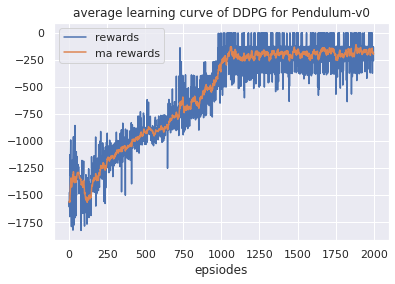

Start Evaluating!
20210816-153356
[20210816-153356: DDPG] Episode:4: Frame:800.0: Reward:-126.2
[20210816-153357: DDPG] Episode:8: Frame:1600.0: Reward:-131.9
[20210816-153357: DDPG] Episode:12: Frame:2400.0: Reward:-130.5
[20210816-153357: DDPG] Episode:16: Frame:3200.0: Reward:-127.8
[20210816-153357: DDPG] Episode:20: Frame:4000.0: Reward:-136.4
[20210816-153358: DDPG] Episode:24: Frame:4800.0: Reward:-125.7
[20210816-153358: DDPG] Episode:28: Frame:5600.0: Reward:-247.5
[20210816-153358: DDPG] Episode:32: Frame:6400.0: Reward:-0.4
[20210816-153359: DDPG] Episode:36: Frame:7200.0: Reward:-131.4
[20210816-153359: DDPG] Episode:40: Frame:8000.0: Reward:-0.0
[20210816-153359: DDPG] Episode:44: Frame:8800.0: Reward:-127.8
[20210816-153359: DDPG] Episode:48: Frame:9600.0: Reward:-353.5
results saved!


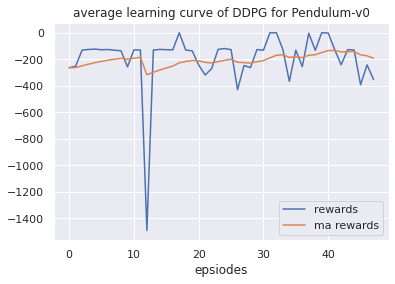

In [19]:
# 2
main()

DDPG Pendulum-v0
Start Training!
20210816-150837
[20210816-150838: DDPG] Episode:16: Frame:3200.0: Reward:-1702.5
[20210816-150838: DDPG] Episode:32: Frame:6400.0: Reward:-1172.7
[20210816-150839: DDPG] Episode:48: Frame:9600.0: Reward:-988.0
[20210816-150843: DDPG] Episode:64: Frame:12800.0: Reward:-1254.8: Loss:13.8323
[20210816-150847: DDPG] Episode:80: Frame:16000.0: Reward:-1170.0: Loss:17.8269
[20210816-150851: DDPG] Episode:96: Frame:19200.0: Reward:-1594.3: Loss:25.5937
[20210816-150854: DDPG] Episode:112: Frame:22400.0: Reward:-1806.7: Loss:32.1534
[20210816-150857: DDPG] Episode:128: Frame:25600.0: Reward:-1753.0: Loss:38.1825
[20210816-150901: DDPG] Episode:144: Frame:28800.0: Reward:-1846.1: Loss:45.5677
[20210816-150905: DDPG] Episode:160: Frame:32000.0: Reward:-1499.3: Loss:49.5448
[20210816-150909: DDPG] Episode:176: Frame:35200.0: Reward:-1584.0: Loss:55.8715
[20210816-150913: DDPG] Episode:192: Frame:38400.0: Reward:-1559.4: Loss:52.8006
[20210816-150918: DDPG] Episode

[20210816-151646: DDPG] Episode:1648: Frame:329600.0: Reward:-127.3: Loss:26.8106
[20210816-151652: DDPG] Episode:1664: Frame:332800.0: Reward:-251.1: Loss:21.0633
[20210816-151658: DDPG] Episode:1680: Frame:336000.0: Reward:-359.4: Loss:22.4057
[20210816-151704: DDPG] Episode:1696: Frame:339200.0: Reward:-130.6: Loss:19.7092
[20210816-151709: DDPG] Episode:1712: Frame:342400.0: Reward:-266.1: Loss:22.6263
[20210816-151715: DDPG] Episode:1728: Frame:345600.0: Reward:-249.6: Loss:23.2935
[20210816-151721: DDPG] Episode:1744: Frame:348800.0: Reward:-260.4: Loss:21.2773
[20210816-151727: DDPG] Episode:1760: Frame:352000.0: Reward:-124.8: Loss:19.4625
[20210816-151733: DDPG] Episode:1776: Frame:355200.0: Reward:-127.8: Loss:18.1942
[20210816-151739: DDPG] Episode:1792: Frame:358400.0: Reward:-129.9: Loss:19.4689
[20210816-151746: DDPG] Episode:1808: Frame:361600.0: Reward:-129.2: Loss:25.5276
[20210816-151752: DDPG] Episode:1824: Frame:364800.0: Reward:-129.4: Loss:20.1587
[20210816-151758

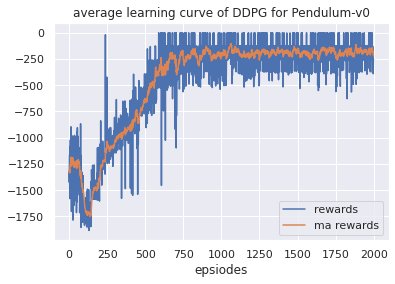

Start Evaluating!
20210816-151901
[20210816-151902: DDPG] Episode:4: Frame:800.0: Reward:-124.8
[20210816-151902: DDPG] Episode:8: Frame:1600.0: Reward:-131.8
[20210816-151902: DDPG] Episode:12: Frame:2400.0: Reward:-130.6
[20210816-151903: DDPG] Episode:16: Frame:3200.0: Reward:-126.6
[20210816-151903: DDPG] Episode:20: Frame:4000.0: Reward:-140.4
[20210816-151903: DDPG] Episode:24: Frame:4800.0: Reward:-124.8
[20210816-151904: DDPG] Episode:28: Frame:5600.0: Reward:-250.1
[20210816-151904: DDPG] Episode:32: Frame:6400.0: Reward:-0.9
[20210816-151904: DDPG] Episode:36: Frame:7200.0: Reward:-130.7
[20210816-151905: DDPG] Episode:40: Frame:8000.0: Reward:-0.5
[20210816-151905: DDPG] Episode:44: Frame:8800.0: Reward:-127.8
[20210816-151906: DDPG] Episode:48: Frame:9600.0: Reward:-347.6
results saved!


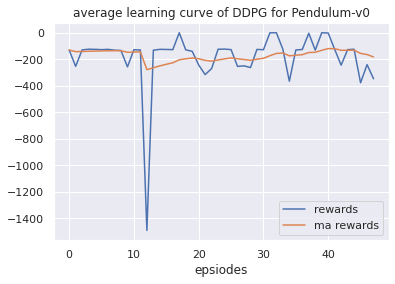

In [13]:
# 1
main()

# LunarLanderContinuous-v2

In [30]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'DDPG'             # name of agent
        self.env_id = 'LunarLanderContinuous-v2'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.4e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.memory_size = 100000       # size of replay buffer
        self.memory_warmup_size = 600  # number of experience stored in memory before learning
        self.learn_freq = 2            # number of steps for one learning 
        self.batch_size = 512          # number of examples in one batch
        self.soft_tau = 0.01           # parm for soft updating target model
        self.actor_lr = 0.00016         # learning rate of policy opt
        self.critic_lr = 0.00016        # learning rate of value opt
        self.gamma = 0.98              # discount rate of reward
        self.epsilon_start = 0.90      # starting epsilon of e-greedy policy
        self.epsilon_end = 0.001        # ending epsilon
        self.epsilon_decay = 1/5000    # e = e_end + (e_start - e_end) * exp(-1. * sample_steps * e_decay)
        self.model = 'Continuous'       # name or type of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 1.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

DDPG LunarLanderContinuous-v2
Start Training!
20210816-174635
[20210816-174635: DDPG] Episode:1: Frame:76.0: Reward:-247.2
[20210816-174635: DDPG] Episode:13: Frame:1177.0: Reward:-212.0
[20210816-174636: DDPG] Episode:23: Frame:2225.0: Reward:-120.0
[20210816-174636: DDPG] Episode:32: Frame:3404.0: Reward:-389.3
[20210816-174636: DDPG] Episode:41: Frame:4443.0: Reward:-506.7
[20210816-174636: DDPG] Episode:50: Frame:5563.0: Reward:-402.2
[20210816-174637: DDPG] Episode:58: Frame:6671.0: Reward:-276.3
[20210816-174637: DDPG] Episode:69: Frame:7713.0: Reward:-387.3
[20210816-174637: DDPG] Episode:78: Frame:8744.0: Reward:-130.2: Loss:34.1420
[20210816-174638: DDPG] Episode:88: Frame:9770.0: Reward:-353.3: Loss:26.9503
[20210816-174640: DDPG] Episode:98: Frame:10854.0: Reward:-18.7: Loss:43.0578
[20210816-174642: DDPG] Episode:109: Frame:11946.0: Reward:-409.4: Loss:53.7591
[20210816-174644: DDPG] Episode:118: Frame:13031.0: Reward:-40.9: Loss:14.6917
[20210816-174645: DDPG] Episode:125:

[20210816-174841: DDPG] Episode:279: Frame:111275.0: Reward:22.2: Loss:-19.6525
[20210816-174843: DDPG] Episode:280: Frame:112275.0: Reward:-52.3: Loss:-11.0626
[20210816-174843: DDPG] Episode:281: Frame:113275.0: Reward:-49.9: Loss:-17.1748
[20210816-174843: DDPG] Episode:282: Frame:114275.0: Reward:-67.2: Loss:-19.7041
[20210816-174844: DDPG] Episode:283: Frame:115275.0: Reward:-67.5: Loss:-14.4664
[20210816-174844: DDPG] Episode:284: Frame:116275.0: Reward:-34.0: Loss:-18.5791
[20210816-174844: DDPG] Episode:285: Frame:117275.0: Reward:-51.1: Loss:-16.8501
[20210816-174845: DDPG] Episode:286: Frame:118275.0: Reward:-63.1: Loss:-17.1493
[20210816-174845: DDPG] Episode:287: Frame:119275.0: Reward:-6.8: Loss:-19.4724
[20210816-174848: DDPG] Episode:288: Frame:120275.0: Reward:-25.1: Loss:-13.0450
[20210816-174851: DDPG] Episode:289: Frame:121275.0: Reward:4.5: Loss:-14.8656
[20210816-174851: DDPG] Episode:290: Frame:122275.0: Reward:5.5: Loss:-19.0512
[20210816-174852: DDPG] Episode:29

[20210816-175059: DDPG] Episode:383: Frame:214380.0: Reward:75.8: Loss:-19.3073
[20210816-175059: DDPG] Episode:384: Frame:215380.0: Reward:36.7: Loss:-19.6122
[20210816-175103: DDPG] Episode:385: Frame:216380.0: Reward:97.8: Loss:-14.7962
[20210816-175106: DDPG] Episode:386: Frame:217380.0: Reward:45.6: Loss:-18.1016
[20210816-175107: DDPG] Episode:387: Frame:218380.0: Reward:10.9: Loss:-19.8970
[20210816-175108: DDPG] Episode:388: Frame:219380.0: Reward:29.7: Loss:-18.5394
[20210816-175112: DDPG] Episode:389: Frame:220380.0: Reward:111.1: Loss:-18.9461
[20210816-175116: DDPG] Episode:390: Frame:221380.0: Reward:110.2: Loss:-17.9363
[20210816-175117: DDPG] Episode:391: Frame:222380.0: Reward:36.2: Loss:-19.1568
[20210816-175118: DDPG] Episode:392: Frame:223380.0: Reward:97.4: Loss:-18.7044
[20210816-175118: DDPG] Episode:393: Frame:224380.0: Reward:134.0: Loss:-21.0567
[20210816-175119: DDPG] Episode:394: Frame:225380.0: Reward:35.0: Loss:-19.9830
[20210816-175119: DDPG] Episode:395: 

[20210816-175330: DDPG] Episode:490: Frame:319297.0: Reward:115.8: Loss:-19.3343
[20210816-175331: DDPG] Episode:491: Frame:320297.0: Reward:103.6: Loss:-13.4375
[20210816-175332: DDPG] Episode:492: Frame:321297.0: Reward:108.0: Loss:-20.7982
[20210816-175332: DDPG] Episode:493: Frame:322297.0: Reward:104.6: Loss:-18.3658
[20210816-175333: DDPG] Episode:494: Frame:323297.0: Reward:46.8: Loss:-22.4698
[20210816-175333: DDPG] Episode:495: Frame:324297.0: Reward:137.0: Loss:-18.7276
[20210816-175333: DDPG] Episode:496: Frame:325297.0: Reward:119.3: Loss:-9.9017
[20210816-175334: DDPG] Episode:497: Frame:326297.0: Reward:89.9: Loss:-16.0085
[20210816-175334: DDPG] Episode:498: Frame:327297.0: Reward:114.8: Loss:-20.1440
[20210816-175335: DDPG] Episode:499: Frame:328297.0: Reward:123.0: Loss:-18.3350
[20210816-175341: DDPG] Episode:500: Frame:329297.0: Reward:101.9: Loss:-19.7254
[20210816-175342: DDPG] Episode:501: Frame:330297.0: Reward:-42.1: Loss:-21.9228
[20210816-175343: DDPG] Episode

[20210816-175549: DDPG] Episode:604: Frame:422817.0: Reward:128.7: Loss:-20.7050
[20210816-175549: DDPG] Episode:605: Frame:423817.0: Reward:107.6: Loss:-21.1188
[20210816-175552: DDPG] Episode:606: Frame:424817.0: Reward:83.3: Loss:-22.9179
[20210816-175552: DDPG] Episode:607: Frame:425817.0: Reward:40.2: Loss:-21.2792
[20210816-175554: DDPG] Episode:608: Frame:426817.0: Reward:90.4: Loss:-19.7563
[20210816-175556: DDPG] Episode:609: Frame:427817.0: Reward:59.5: Loss:-21.5055
[20210816-175559: DDPG] Episode:610: Frame:428817.0: Reward:86.2: Loss:-21.1492
[20210816-175608: DDPG] Episode:612: Frame:430669.0: Reward:90.9: Loss:-13.3276
[20210816-175609: DDPG] Episode:613: Frame:431669.0: Reward:62.9: Loss:-15.4671
[20210816-175610: DDPG] Episode:614: Frame:432669.0: Reward:61.5: Loss:-20.9868
[20210816-175611: DDPG] Episode:615: Frame:433669.0: Reward:50.6: Loss:-21.3380
[20210816-175611: DDPG] Episode:616: Frame:434669.0: Reward:65.7: Loss:-20.7002
[20210816-175612: DDPG] Episode:617: F

[20210816-175828: DDPG] Episode:709: Frame:527140.0: Reward:112.1: Loss:-19.6094
[20210816-175829: DDPG] Episode:710: Frame:528140.0: Reward:105.4: Loss:-20.4962
[20210816-175830: DDPG] Episode:711: Frame:529140.0: Reward:129.6: Loss:-22.2161
[20210816-175831: DDPG] Episode:712: Frame:530140.0: Reward:84.4: Loss:-20.5874
[20210816-175831: DDPG] Episode:713: Frame:531140.0: Reward:83.0: Loss:-19.6129
[20210816-175832: DDPG] Episode:714: Frame:532140.0: Reward:133.0: Loss:-21.2007
[20210816-175832: DDPG] Episode:715: Frame:533140.0: Reward:147.1: Loss:-21.4840
[20210816-175833: DDPG] Episode:716: Frame:534140.0: Reward:74.0: Loss:-18.7543
[20210816-175833: DDPG] Episode:717: Frame:535140.0: Reward:118.5: Loss:-20.1014
[20210816-175834: DDPG] Episode:718: Frame:536140.0: Reward:127.7: Loss:-20.6056
[20210816-175837: DDPG] Episode:719: Frame:537140.0: Reward:157.4: Loss:-3.5248
[20210816-175839: DDPG] Episode:720: Frame:538140.0: Reward:122.6: Loss:-20.7345
[20210816-175841: DDPG] Episode:

[20210816-180127: DDPG] Episode:830: Frame:638570.0: Reward:57.0: Loss:-20.5726
[20210816-180128: DDPG] Episode:831: Frame:639570.0: Reward:137.8: Loss:-19.7097
[20210816-180132: DDPG] Episode:833: Frame:641378.0: Reward:98.0: Loss:-19.3766
[20210816-180135: DDPG] Episode:834: Frame:642378.0: Reward:151.5: Loss:-11.7857
[20210816-180136: DDPG] Episode:836: Frame:643977.0: Reward:9.1: Loss:-16.0109
[20210816-180139: DDPG] Episode:837: Frame:644977.0: Reward:82.7: Loss:-18.6919
[20210816-180141: DDPG] Episode:838: Frame:645977.0: Reward:181.6: Loss:-21.2703
[20210816-180141: DDPG] Episode:840: Frame:647163.0: Reward:205.8: Loss:-21.7013
[20210816-180142: DDPG] Episode:842: Frame:648437.0: Reward:180.5: Loss:-18.2430
[20210816-180143: DDPG] Episode:843: Frame:649437.0: Reward:140.4: Loss:-20.4201
[20210816-180152: DDPG] Episode:845: Frame:650754.0: Reward:159.5: Loss:-19.3633
[20210816-180153: DDPG] Episode:846: Frame:651754.0: Reward:104.3: Loss:-20.2731
[20210816-180155: DDPG] Episode:8

[20210816-180533: DDPG] Episode:1010: Frame:765838.0: Reward:237.1: Loss:-17.5042
[20210816-180534: DDPG] Episode:1013: Frame:767172.0: Reward:221.9: Loss:-19.6530
[20210816-180535: DDPG] Episode:1014: Frame:768172.0: Reward:103.1: Loss:-20.6795
[20210816-180538: DDPG] Episode:1017: Frame:769895.0: Reward:94.5: Loss:-12.5412
[20210816-180540: DDPG] Episode:1020: Frame:771547.0: Reward:77.0: Loss:-20.7128
[20210816-180543: DDPG] Episode:1023: Frame:773064.0: Reward:239.0: Loss:-20.1834
[20210816-180548: DDPG] Episode:1026: Frame:774180.0: Reward:271.9: Loss:-21.2312
[20210816-180552: DDPG] Episode:1028: Frame:775266.0: Reward:249.2: Loss:-18.9654
[20210816-180552: DDPG] Episode:1030: Frame:776552.0: Reward:271.6: Loss:-18.2505
[20210816-180555: DDPG] Episode:1034: Frame:778039.0: Reward:246.4: Loss:-19.9797
[20210816-180559: DDPG] Episode:1036: Frame:779143.0: Reward:250.6: Loss:-22.4585
[20210816-180604: DDPG] Episode:1038: Frame:780383.0: Reward:48.9: Loss:-19.9497
[20210816-180606: D

[20210816-181001: DDPG] Episode:1269: Frame:891235.0: Reward:217.4: Loss:-21.4179
[20210816-181004: DDPG] Episode:1272: Frame:892298.0: Reward:6.2: Loss:-22.4524
[20210816-181006: DDPG] Episode:1274: Frame:893300.0: Reward:208.9: Loss:-22.7603
[20210816-181008: DDPG] Episode:1276: Frame:894424.0: Reward:237.1: Loss:-16.9143
[20210816-181009: DDPG] Episode:1277: Frame:895424.0: Reward:89.8: Loss:-14.9175
[20210816-181010: DDPG] Episode:1280: Frame:896967.0: Reward:77.0: Loss:-23.4052
[20210816-181013: DDPG] Episode:1285: Frame:898445.0: Reward:279.5: Loss:-24.4658
[20210816-181015: DDPG] Episode:1287: Frame:899723.0: Reward:188.9: Loss:-21.1928
[20210816-181021: DDPG] Episode:1291: Frame:900944.0: Reward:267.7: Loss:-23.4706
[20210816-181024: DDPG] Episode:1294: Frame:902578.0: Reward:86.5: Loss:-9.4326
[20210816-181025: DDPG] Episode:1298: Frame:903719.0: Reward:222.7: Loss:-23.0245
[20210816-181026: DDPG] Episode:1301: Frame:905043.0: Reward:262.3: Loss:-22.8201
[20210816-181033: DDPG

[20210816-181448: DDPG] Episode:1544: Frame:1021102.0: Reward:97.5: Loss:-24.7586
[20210816-181450: DDPG] Episode:1547: Frame:1022195.0: Reward:280.1: Loss:-26.2204
[20210816-181454: DDPG] Episode:1550: Frame:1023205.0: Reward:208.9: Loss:-25.0338
[20210816-181458: DDPG] Episode:1553: Frame:1024509.0: Reward:248.2: Loss:-26.1320
[20210816-181502: DDPG] Episode:1557: Frame:1026472.0: Reward:98.4: Loss:-16.0395
[20210816-181506: DDPG] Episode:1560: Frame:1027722.0: Reward:283.2: Loss:-19.2691
[20210816-181509: DDPG] Episode:1563: Frame:1028820.0: Reward:289.3: Loss:-13.7788
[20210816-181512: DDPG] Episode:1566: Frame:1030154.0: Reward:242.9: Loss:-25.5975
[20210816-181514: DDPG] Episode:1568: Frame:1031686.0: Reward:102.5: Loss:-25.3120
[20210816-181515: DDPG] Episode:1569: Frame:1032686.0: Reward:84.5: Loss:-26.0346
[20210816-181520: DDPG] Episode:1572: Frame:1033704.0: Reward:262.1: Loss:-26.6738
[20210816-181521: DDPG] Episode:1575: Frame:1034968.0: Reward:210.7: Loss:-26.3846
[202108

[20210816-181958: DDPG] Episode:1838: Frame:1147887.0: Reward:242.1: Loss:-27.1612
[20210816-182000: DDPG] Episode:1842: Frame:1149050.0: Reward:255.1: Loss:-20.7198
[20210816-182000: DDPG] Episode:1843: Frame:1150050.0: Reward:82.9: Loss:-24.8046
[20210816-182005: DDPG] Episode:1847: Frame:1151932.0: Reward:130.7: Loss:-22.4874
[20210816-182006: DDPG] Episode:1850: Frame:1153365.0: Reward:268.0: Loss:-23.9636
[20210816-182013: DDPG] Episode:1854: Frame:1154725.0: Reward:242.2: Loss:-25.7277
[20210816-182014: DDPG] Episode:1857: Frame:1155953.0: Reward:249.4: Loss:-27.8090
[20210816-182022: DDPG] Episode:1860: Frame:1157347.0: Reward:200.4: Loss:-27.5398
[20210816-182024: DDPG] Episode:1862: Frame:1158511.0: Reward:207.6: Loss:-28.0446
[20210816-182024: DDPG] Episode:1863: Frame:1159511.0: Reward:-38.2: Loss:-21.7939
[20210816-182026: DDPG] Episode:1866: Frame:1160672.0: Reward:229.8: Loss:-28.6956
[20210816-182027: DDPG] Episode:1869: Frame:1161998.0: Reward:145.3: Loss:-26.7598
[2021

[20210816-182538: DDPG] Episode:2135: Frame:1272462.0: Reward:216.3: Loss:-25.9142
[20210816-182539: DDPG] Episode:2138: Frame:1274253.0: Reward:-21.3: Loss:-25.6155
[20210816-182545: DDPG] Episode:2141: Frame:1275273.0: Reward:240.3: Loss:-15.6902
[20210816-182551: DDPG] Episode:2144: Frame:1276318.0: Reward:234.4: Loss:-24.9502
[20210816-182552: DDPG] Episode:2147: Frame:1277321.0: Reward:235.9: Loss:-32.0017
[20210816-182552: DDPG] Episode:2148: Frame:1278321.0: Reward:141.7: Loss:-25.4368
[20210816-182556: DDPG] Episode:2152: Frame:1279641.0: Reward:262.9: Loss:-25.5166
[20210816-182559: DDPG] Episode:2155: Frame:1281434.0: Reward:116.2: Loss:-20.6844
[20210816-182605: DDPG] Episode:2159: Frame:1282631.0: Reward:253.8: Loss:-29.3219
[20210816-182607: DDPG] Episode:2162: Frame:1283754.0: Reward:261.8: Loss:-26.4660
[20210816-182610: DDPG] Episode:2165: Frame:1284777.0: Reward:257.7: Loss:-31.2039
[20210816-182612: DDPG] Episode:2168: Frame:1285887.0: Reward:209.6: Loss:-32.4134
[202

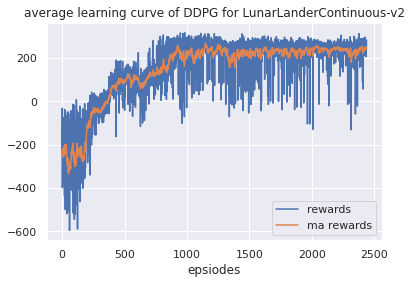

Start Evaluating!
20210816-183132
[20210816-183133: DDPG] Episode:1: Frame:298.0: Reward:274.4
[20210816-183134: DDPG] Episode:2: Frame:884.0: Reward:250.9
[20210816-183135: DDPG] Episode:3: Frame:1585.0: Reward:200.7
[20210816-183136: DDPG] Episode:4: Frame:1856.0: Reward:283.3
[20210816-183137: DDPG] Episode:5: Frame:2551.0: Reward:226.5
[20210816-183137: DDPG] Episode:6: Frame:3551.0: Reward:130.7
[20210816-183137: DDPG] Episode:7: Frame:4101.0: Reward:225.9
[20210816-183137: DDPG] Episode:8: Frame:4264.0: Reward:257.1
[20210816-183138: DDPG] Episode:9: Frame:4545.0: Reward:277.8
[20210816-183139: DDPG] Episode:10: Frame:4822.0: Reward:299.3
[20210816-183139: DDPG] Episode:11: Frame:5284.0: Reward:217.9
[20210816-183139: DDPG] Episode:12: Frame:6017.0: Reward:202.7
[20210816-183140: DDPG] Episode:13: Frame:6605.0: Reward:237.5
[20210816-183140: DDPG] Episode:14: Frame:6781.0: Reward:259.5
[20210816-183140: DDPG] Episode:15: Frame:7043.0: Reward:262.7
[20210816-183140: DDPG] Episode:

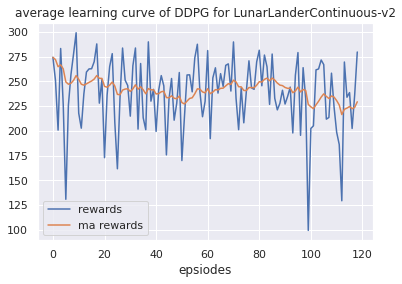

In [31]:
# 0.00016
main()